In [1]:
import pyodbc
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime

# Baixando bases necessárias

Vamos aplicar esse caso para regiões de saúde, pois é o escopo dos modelos que testamos 

In [30]:
host = '***'
port = ***
uid = '***'
pwd = '***'
driver = 'Dremio Connector'

cnxn = pyodbc.connect("Driver={};ConnectionType=Direct;HOST={};PORT={};AuthenticationType=Plain;UID={};PWD={}".format(driver, host,port,uid,pwd),autocommit=True)

sql = '''SELECT * FROM "Analytics Layer"."Epidemiológico"."Nascidos Vivos por Região de Saúde"
         WHERE substr(COD_REGSAUD, 1, 2) = '52' '''

df = pd.read_sql(sql,cnxn)
df.head()


C:\Users\Lapei_Cigets\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,uf_sigla,cod_regsaud,regiao_saude,ano,mes,quantidade
0,GO,52008,Norte,2022,06,18
1,GO,52003,Entorno Norte,2022,06,89
2,GO,52009,Oeste I,2022,06,14
3,GO,52012,Rio Vermelho,2022,06,43
4,GO,52001,Central,2022,06,238


In [31]:
cols = ['ano','mes']
df['ano_mes'] = df[cols].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)

df_t = df.drop(columns=['ano','mes'])

df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4859 entries, 0 to 4858
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uf_sigla      4859 non-null   object
 1   cod_regsaud   4859 non-null   object
 2   regiao_saude  4859 non-null   object
 3   quantidade    4859 non-null   int64 
 4   ano_mes       4859 non-null   object
dtypes: int64(1), object(4)
memory usage: 189.9+ KB


Vamos usar o API criada pelo Wanderson para verificar os procedimentos necessários para cada nascido vivo de um mês de referência e região de saúde

In [32]:
dfs = [] 

for _, row in df_t.iterrows():
    qtd_nascidos = round(row['quantidade'])
    ano_mes = row['ano_mes']
    url = f'http://200.137.215.27:5025/calcula_procedimentos?mes_ano={ano_mes}&nascidos_vivos={qtd_nascidos}'
    print("Chamando", url)
    resultado = requests.get(url)
    df_it = pd.DataFrame(resultado.json())
    df_it['ano_mes'] = row['ano_mes'] 
    df_it['qtd_nascidos'] = qtd_nascidos
    df_it['regiao'] = row['cod_regsaud']
    dfs.append(df_it)
    df_full = pd.concat(dfs, ignore_index=True)

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=18
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=89
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=14
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=43
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=238
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=136
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=123
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=35
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=51
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nascidos_vivos=23
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-06&nas

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=314
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=141
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=158
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=195
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=123
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=307
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=180
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=614
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=104
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2022-01&nascidos_vivos=2069
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=202

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-09&nascidos_vivos=1065
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=105
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=1935
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=293
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=189
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=635
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=108
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=43
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=465
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-08&nascidos_vivos=131
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=202

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-04&nascidos_vivos=522
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-04&nascidos_vivos=132
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=2183
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=200
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=282
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=684
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=145
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=353
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=138
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2021-03&nascidos_vivos=154
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=202

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-11&nascidos_vivos=111
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-11&nascidos_vivos=468
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-11&nascidos_vivos=1888
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=186
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=608
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=1923
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=115
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=157
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=268
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-10&nascidos_vivos=338
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-06&nascidos_vivos=257
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-06&nascidos_vivos=170
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-06&nascidos_vivos=1085
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-06&nascidos_vivos=503
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-05&nascidos_vivos=96
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-05&nascidos_vivos=341
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-05&nascidos_vivos=2231
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-05&nascidos_vivos=148
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-05&nascidos_vivos=1137
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-05&nascidos_vivos=234
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-01&nascidos_vivos=1139
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-01&nascidos_vivos=99
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-01&nascidos_vivos=340
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-01&nascidos_vivos=264
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-01&nascidos_vivos=128
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2020-01&nascidos_vivos=187
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-12&nascidos_vivos=193
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-12&nascidos_vivos=927
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-12&nascidos_vivos=55
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-12&nascidos_vivos=145
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=123
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=267
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=242
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=93
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=1074
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=110
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-08&nascidos_vivos=133
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-07&nascidos_vivos=60
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-07&nascidos_vivos=123
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-07&nascidos_vivos=115
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=60
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=132
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=190
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=561
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=353
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=736
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=288
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=157
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-03&nascidos_vivos=228
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-02&nascidos_vivos=287
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2019-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=137
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=50
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=313
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=1107
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=2224
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=1062
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=274
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=272
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=515
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-10&nascidos_vivos=118
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=142
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=342
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=603
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=292
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=188
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=278
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=1217
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=251
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=190
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018-05&nascidos_vivos=54
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2018

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=637
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=110
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=1042
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=322
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=93
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=134
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=55
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=473
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=163
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-12&nascidos_vivos=2212
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=1131
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=2321
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=513
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=325
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=55
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=344
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=321
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=149
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=261
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-07&nascidos_vivos=211
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=201

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=518
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=44
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=84
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=157
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=192
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=2014
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=241
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=98
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=188
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-02&nascidos_vivos=131
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2017-0

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=1054
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=47
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=306
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=470
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=2178
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=180
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=211
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=652
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=136
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-09&nascidos_vivos=157
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=201

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=545
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=88
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=299
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=121
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=52
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=1206
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=304
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=2389
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=124
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016-04&nascidos_vivos=683
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2016

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-12&nascidos_vivos=1136
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=2169
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=672
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=306
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=150
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=507
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=110
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=242
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=1119
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-11&nascidos_vivos=102
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-07&nascidos_vivos=551
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-07&nascidos_vivos=160
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-07&nascidos_vivos=325
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=308
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=132
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=57
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=241
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=178
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=99
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-06&nascidos_vivos=372
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-0

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-02&nascidos_vivos=105
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-02&nascidos_vivos=134
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-02&nascidos_vivos=530
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-02&nascidos_vivos=117
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-02&nascidos_vivos=187
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-01&nascidos_vivos=634
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-01&nascidos_vivos=1095
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-01&nascidos_vivos=316
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-01&nascidos_vivos=2327
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2015-01&nascidos_vivos=1175
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-09&nascidos_vivos=523
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-09&nascidos_vivos=198
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-09&nascidos_vivos=269
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-09&nascidos_vivos=154
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-09&nascidos_vivos=1102
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-09&nascidos_vivos=2466
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-08&nascidos_vivos=140
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-08&nascidos_vivos=130
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-08&nascidos_vivos=1059
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-08&nascidos_vivos=168
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=130
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=187
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=2375
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=311
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=571
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=1133
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=61
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-04&nascidos_vivos=655
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-03&nascidos_vivos=206
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2014-03&nascidos_vivos=272
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=201

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=180
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=122
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=262
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=1031
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=121
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=315
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=76
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=289
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-11&nascidos_vivos=158
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-10&nascidos_vivos=494
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=311
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=99
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=153
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=202
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=166
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=111
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=344
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=264
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=1018
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-06&nascidos_vivos=493
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=325
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=144
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=1059
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=2273
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=120
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=519
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=323
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=193
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=97
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013-01&nascidos_vivos=56
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2013

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=1029
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=166
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=185
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=267
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=1017
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=183
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=616
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=306
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=137
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-08&nascidos_vivos=118
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=141
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=193
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=277
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=1130
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=198
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=1151
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=265
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=560
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=664
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2012-03&nascidos_vivos=356
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=190
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=105
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=132
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=296
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=994
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=97
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=91
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=211
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=213
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-10&nascidos_vivos=978
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-1

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=113
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=88
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=205
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=268
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=226
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=295
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=1046
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=508
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=446
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2011-05&nascidos_vivos=1076
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=201

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=255
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=250
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=114
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=929
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=286
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=552
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=247
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=173
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=54
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-12&nascidos_vivos=154
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=206
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=96
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=109
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=190
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=982
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=63
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=987
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=278
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=271
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-07&nascidos_vivos=139
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-0

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=207
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=116
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=141
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=294
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=473
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=879
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=57
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=112
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=2012
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-02&nascidos_vivos=84
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2010-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-10&nascidos_vivos=600
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=53
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=453
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=146
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=259
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=274
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=124
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=1015
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=569
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-09&nascidos_vivos=279
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-05&nascidos_vivos=568
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-05&nascidos_vivos=195
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=107
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=167
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=184
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=179
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=1064
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=2205
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=247
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2009-04&nascidos_vivos=99
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=200

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-12&nascidos_vivos=2000
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-12&nascidos_vivos=257
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-12&nascidos_vivos=358
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=108
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=884
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=316
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=85
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=109
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=148
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-11&nascidos_vivos=223
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-07&nascidos_vivos=83
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-07&nascidos_vivos=138
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-07&nascidos_vivos=241
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-07&nascidos_vivos=921
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-06&nascidos_vivos=1967
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-06&nascidos_vivos=96
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-06&nascidos_vivos=42
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-06&nascidos_vivos=955
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-06&nascidos_vivos=295
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-06&nascidos_vivos=104
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-0

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-02&nascidos_vivos=202
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-02&nascidos_vivos=202
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-02&nascidos_vivos=986
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-02&nascidos_vivos=65
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-02&nascidos_vivos=113
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-01&nascidos_vivos=117
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-01&nascidos_vivos=87
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-01&nascidos_vivos=1942
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-01&nascidos_vivos=439
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-01&nascidos_vivos=182
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2008-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-09&nascidos_vivos=937
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-09&nascidos_vivos=94
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-09&nascidos_vivos=118
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-09&nascidos_vivos=228
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-09&nascidos_vivos=259
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-09&nascidos_vivos=1817
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-08&nascidos_vivos=68
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-08&nascidos_vivos=415
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-08&nascidos_vivos=219
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-08&nascidos_vivos=515
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=231
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=281
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=170
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=293
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=190
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=74
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-04&nascidos_vivos=119
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-03&nascidos_vivos=165
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-03&nascidos_vivos=323
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-03&nascidos_vivos=224
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2007-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=415
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=141
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=261
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=140
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=976
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=61
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=852
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-11&nascidos_vivos=85
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-10&nascidos_vivos=169
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-10&nascidos_vivos=154
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-1

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=1048
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=321
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=535
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=266
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=144
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=232
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=1921
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=185
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-06&nascidos_vivos=127
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-05&nascidos_vivos=1062
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=261
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=1070
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=223
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=170
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=548
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=981
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=77
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=118
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=96
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2006-01&nascidos_vivos=389
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=1915
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=574
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=137
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=308
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=93
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=1073
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=467
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=204
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=118
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-08&nascidos_vivos=88
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=294
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=157
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=73
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=222
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=271
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=301
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=2334
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=1088
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=616
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2005-03&nascidos_vivos=258
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=200

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=121
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=245
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=138
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=129
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=443
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=19
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=1915
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=317
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=106
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-10&nascidos_vivos=251
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=225
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=297
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=260
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=333
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=2155
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=89
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=157
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=258
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=535
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004-05&nascidos_vivos=178
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2004

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=163
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=117
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=69
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=1070
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=130
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=411
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=273
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=227
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=75
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-12&nascidos_vivos=217
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=201
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=379
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=75
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=241
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=199
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=582
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=147
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=1100
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=183
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-07&nascidos_vivos=263
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=232
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=164
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=289
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=426
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=325
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=133
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=1008
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=103
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=80
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003-02&nascidos_vivos=291
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2003

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=128
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=102
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=1019
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=291
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=156
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=346
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=409
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=93
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=279
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-09&nascidos_vivos=313
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-05&nascidos_vivos=208
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=137
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=1063
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=121
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=510
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=272
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=217
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=1107
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=150
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2002-04&nascidos_vivos=620
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-12&nascidos_vivos=108
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-12&nascidos_vivos=196
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=251
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=185
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=1989
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=66
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=375
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=92
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=143
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-11&nascidos_vivos=432
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-07&nascidos_vivos=272
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-07&nascidos_vivos=1063
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-07&nascidos_vivos=115
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=253
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=134
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=284
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=257
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=100
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=543
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-06&nascidos_vivos=925
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=200

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-02&nascidos_vivos=128
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-02&nascidos_vivos=183
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-02&nascidos_vivos=183
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-02&nascidos_vivos=126
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-01&nascidos_vivos=1031
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-01&nascidos_vivos=1001
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-01&nascidos_vivos=253
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-01&nascidos_vivos=169
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-01&nascidos_vivos=124
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2001-01&nascidos_vivos=272
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=20

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-09&nascidos_vivos=53
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-09&nascidos_vivos=1074
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-09&nascidos_vivos=212
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-09&nascidos_vivos=235
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-09&nascidos_vivos=411
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-08&nascidos_vivos=625
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-08&nascidos_vivos=354
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-08&nascidos_vivos=152
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-08&nascidos_vivos=208
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-08&nascidos_vivos=282
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000

Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-04&nascidos_vivos=2197
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-04&nascidos_vivos=186
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-04&nascidos_vivos=660
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-04&nascidos_vivos=148
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-04&nascidos_vivos=382
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-04&nascidos_vivos=73
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-03&nascidos_vivos=274
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-03&nascidos_vivos=304
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-03&nascidos_vivos=168
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000-03&nascidos_vivos=248
Chamando http://200.137.215.27:5025/calcula_procedimentos?mes_ano=2000

In [59]:
df_full.head()
#df.to_csv("total_procedimentos_PBI.csv")

,codigo_sigtap,mes,parametro,procedimento,tipo_procedimento,gestantes,nivel_atencao,categoria_profissional_fim,quantidade,mes_gestacao,ano_mes,qtd_nascidos,regiao
0,301010110,1,1.0,Consulta pré-natal,Consultas ou Visitas,Todas,APS,Médico ou Enfermeiro,18.0,2021-10-01,2022-06,18,52008
1,203010019,2,1.0,Colpocitologia,Exames,Todas,APS,Biomédico,18.0,2021-11-01,2022-06,18,52008
2,301010110,2,1.0,Consulta pré-natal,Consultas ou Visitas,Todas,APS,Médico ou Enfermeiro,18.0,2021-11-01,2022-06,18,52008
3,202020479,2,0.5,Coombs Indireto,Exames,Todas,Especializada e APS,Biomédico,9.0,2021-11-01,2022-06,18,52008
4,202020355,2,1.0,Eletroforese de Hemoglobina,Exames,Todas,Especializada e APS,Biomédico,18.0,2021-11-01,2022-06,18,52008


**Descrição de variáveis** 
- codigo_sigtap: código de identificação única de um procedimento (um procedimento pode ocorrer múltiplas vezes ao longo da gestação, como o pré-natal)
- mes: mês de referência que aquele procedimento deve ser realizado (mês 1 = primeiro mês de gestação)
- parametro: quantos procedimentos naquele mês para o total de gestantes devem ser realizados (ex.: existem procedimentos que só metade das gestantes precisam fazer) 
- procedimento: nome do procedimento
- tipo_procedimento: tipo de procedimento
- gestantes: tipo de gestante que realiza os procedimentos. Via de regra pode ser todas ou, para alguns procedimentos, as de alto risco
- nivel_atencao: nível de atenção onde aquele procedimento geralmente é realizado
- categoria_profissional_fim: a categoria profissional finalística que executa o procedimento. Existem categorias de apoio, mas estamos mapeando apenas a categoria fim 
- quantidade: quantidade de procedimentos que devem r

# Calculando procedimentos por mês 

Agora vamos calcular a quantidade de procedimentos por mês de realização do procedimento

In [46]:
procedimentos_mes = df_full.groupby(['regiao','ano_mes','mes_gestacao','qtd_nascidos',
                                     'codigo_sigtap'])['quantidade'].sum().reset_index()

In [47]:
procedimentos_mes[["mes_gestacao"]] = procedimentos_mes[["mes_gestacao"]].apply(pd.to_datetime) 
procedimentos_mes['codigo_sigtap'] = procedimentos_mes['codigo_sigtap'].astype('str') 

procedimentos_mes.head()

,regiao,ano_mes,mes_gestacao,qtd_nascidos,codigo_sigtap,quantidade
0,52001,2000-01,1999-05-01,2092,301010110,2092.0
1,52001,2000-01,1999-06-01,2092,202020355,2092.0
2,52001,2000-01,1999-06-01,2092,202020380,2092.0
3,52001,2000-01,1999-06-01,2092,202020479,1046.0
4,52001,2000-01,1999-06-01,2092,202030180,2092.0


Considerando o total de procedimentos, vamos computar em horas primeiro. Para isso, vamos ler uma planilha com estimativas de tempos dos procedimento. **Em uma implementação de sistema, é requisito que os tempos sejam ajustados pelo usuário.** 

In [48]:
tempos = pd.read_excel("procedimentos_tempos.xlsx") 
tempos['codigo_sigtap'] = tempos['codigo_sigtap'].astype('str')
tempos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   codigo_sigtap  37 non-null     object 
 1   procedimento   37 non-null     object 
 2   Tempo          37 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1016.0+ bytes


In [49]:
df_tempos = procedimentos_mes.merge(tempos, on = 'codigo_sigtap', how = 'left')

df_tempos['horasProfissionais'] = df_tempos['quantidade'] * df_tempos['Tempo'] 

df_tempos.head()

,regiao,ano_mes,mes_gestacao,qtd_nascidos,codigo_sigtap,quantidade,procedimento,Tempo,horasProfissionais
0,52001,2000-01,1999-05-01,2092,301010110,2092.0,Consulta pré-natal,0.5,1046.0
1,52001,2000-01,1999-06-01,2092,202020355,2092.0,Eletroforese de Hemoglobina,0.2,418.4
2,52001,2000-01,1999-06-01,2092,202020380,2092.0,Hemograma,0.2,418.4
3,52001,2000-01,1999-06-01,2092,202020479,1046.0,Coombs Indireto,0.2,209.2
4,52001,2000-01,1999-06-01,2092,202030180,2092.0,"Toxoplasmose IgM, IgG",0.2,418.4


Agora vamos ver os perfis de profissionais que atuam nos procedimentos. Temos profissionais que podem atuar em mais de um procedimento (ex.: médicos e enfermeiros podem atuar no pré-natal). Por isso que tem essa contagem resultando no df mix. Se o procedimento é realizado por dois profissionais, dividimos as horasProfissionais para duas categorias. 

In [50]:
df_profissionais = pd.read_excel('procedimentos_profissionais.xlsx')

df_profissionais['codigo_sigtap'] = df_profissionais['codigo_sigtap'].astype('str')

mix = df_profissionais.groupby(['codigo_sigtap'])['CBO'].count().reset_index()

mix = mix.rename(columns={"CBO":"qtd"})

In [51]:
df_tempos = df_tempos.merge(mix, on = 'codigo_sigtap', how = 'left') 

df_tempos['horas_categoria'] = df_tempos['horasProfissionais'] / df_tempos['qtd']

df_tempos.head()

,regiao,ano_mes,mes_gestacao,qtd_nascidos,codigo_sigtap,quantidade,procedimento,Tempo,horasProfissionais,qtd,horas_categoria
0,52001,2000-01,1999-05-01,2092,301010110,2092.0,Consulta pré-natal,0.5,1046.0,2,523.0
1,52001,2000-01,1999-06-01,2092,202020355,2092.0,Eletroforese de Hemoglobina,0.2,418.4,1,418.4
2,52001,2000-01,1999-06-01,2092,202020380,2092.0,Hemograma,0.2,418.4,1,418.4
3,52001,2000-01,1999-06-01,2092,202020479,1046.0,Coombs Indireto,0.2,209.2,1,209.2
4,52001,2000-01,1999-06-01,2092,202030180,2092.0,"Toxoplasmose IgM, IgG",0.2,418.4,1,418.4


In [56]:
#df_tempos.to_csv('procedimentos_hora_PBI_v1.csv')

Aqui dividimos o quantitativo de profissionais por 126, que é o correspondente de horas líquidas mensais de um profissional de 40h semanais para calcular a métrica da FTE40

In [54]:
df_tempo_prof = df_tempos.merge(df_profissionais, on = 'codigo_sigtap', how = 'left')

df_tempo_prof = df_tempo_prof.groupby(['regiao', 'mes_gestacao', 'qtd_nascidos', 'ano_mes',
                       'categoria_profissional_fim','CBO'])['horas_categoria'].sum().reset_index()

df_tempo_prof['fte40'] = df_tempo_prof['horas_categoria']/126

df_tempo_prof.head(40)

,regiao,mes_gestacao,qtd_nascidos,ano_mes,categoria_profissional_fim,CBO,horas_categoria,fte40
0,52001,1999-05-01,2092,2000-01,Enfermeiro,223505,523.000,4.150794
1,52001,1999-05-01,2092,2000-01,Médico,225130,523.000,4.150794
2,52001,1999-06-01,2085,2000-02,Enfermeiro,223505,521.250,4.136905
3,52001,1999-06-01,2085,2000-02,Médico,225130,521.250,4.136905
4,52001,1999-06-01,2092,2000-01,ACS,515105,418.400,3.320635
5,52001,1999-06-01,2092,2000-01,Biomédico,221205,4811.600,38.187302
6,52001,1999-06-01,2092,2000-01,Enfermeiro,223505,523.000,4.150794
7,52001,1999-06-01,2092,2000-01,Médico,225130,523.000,4.150794
8,52001,1999-07-01,2085,2000-02,ACS,515105,417.000,3.309524
9,52001,1999-07-01,2085,2000-02,Biomédico,221205,4795.500,38.059524


Tomando uma região como referência para fazer as análises

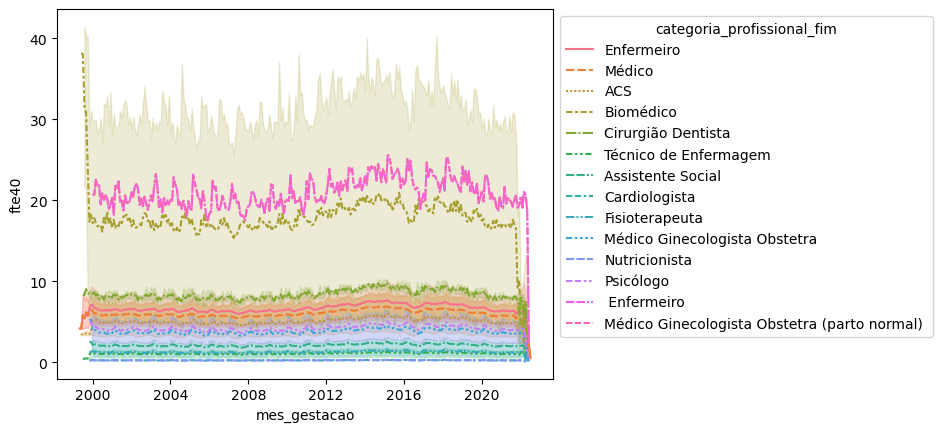

In [53]:
# tomando um regiao como referência 

df_11001 = df_tempo_prof[(df_tempo_prof.regiao =='52001')]

ax = sns.lineplot(x = "mes_gestacao", y = "fte40", data=df_11001, hue = 'categoria_profissional_fim',
              style="categoria_profissional_fim")

#x_dates = df_11001['mes_gestacao'].dt.strftime('%Y-%m-%d').sort_values().unique()

#ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()


In [57]:
# salvando para jogar no pbi 

# df_tempo_prof.to_csv('df_completoPBI_v2.csv')